# Testing modular code

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## Here we define the egg box model function $\left(\cos(x/2)\cos(y/2)+2\right)^5$. For the domain $[0,10\pi] \times [0,10\pi]$, we show the output of the function represented as a color map

In [2]:
from toy_models import eggbox_2d as func

Text(0.5, 1.0, 'Plot of true function value in domain $[0,10\\pi]\\times[0,10\\pi]$')

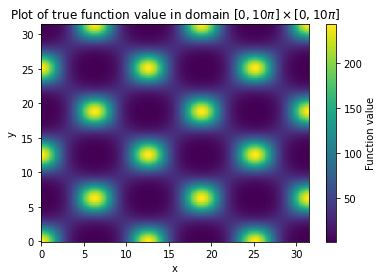

In [3]:
xx = np.arange(0,10*np.pi,0.1) 
yy = np.arange(0,10*np.pi,0.1) 

fig, ax = plt.subplots()
xx, yy = np.meshgrid(xx, yy)
im = ax.pcolormesh(xx,yy,func(xx,yy))
fig.colorbar(im, ax=ax,label='Function value')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Plot of true function value in domain $[0,10\pi]\times[0,10\pi]$')

## We also plot the true likelihood assuming that the measurement is 100 and $\sigma=10$

In [4]:
from recommend import likelihood0

mu = 100
sigma = 10

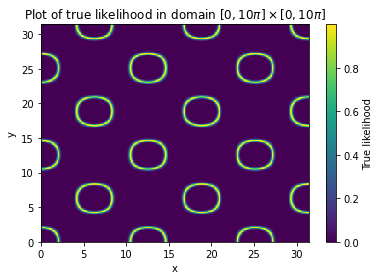

In [5]:
fig, ax = plt.subplots()
xx = np.arange(0,10*np.pi,0.1) 
yy = np.arange(0,10*np.pi,0.1) 
xx, yy = np.meshgrid(xx, yy)
im = plt.pcolormesh(xx,yy, likelihood0(func(xx,yy),mu=mu,sigma=sigma))
plt.xlim(0,10*np.pi)
plt.ylim(0,10*np.pi)
fig.colorbar(im, ax=ax,label='True likelihood')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Plot of true likelihood in domain $[0,10\pi]\times[0,10\pi]$')
plt.show()

## Next, we build the Bayesian NN that will be used as a proxy observable calculator in the MLS setup

In [6]:
from networks import BNNModel

model = BNNModel(input_size = 2, hidden_size = 50, num_hidden_layers=3, output_size = 1)

In [7]:
import torchbnn as bnn
import torch.optim as optim

#to-do: modularize loss function

criterion = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Try 100 random (x,y) points. Train NN and plot predicted likelihood. Note that we do not recommend points at this initial stage. 

In [8]:
xy0 = np.random.rand(100,2)*10*np.pi
out0 = func(xy0[:,0],xy0[:,1])

In [9]:
xy = xy0
out = out0
newdat = np.column_stack((xy,out))

In [10]:
batch_size = 32
num_epochs = 1000

In [11]:
newdat = np.column_stack((xy,out))
train_dataloader = DataLoader(newdat, batch_size=batch_size,
                              shuffle=True)

num_good_1sigma = 0 #to count number of good points
num_good_2sigma = 0
for i in range(newdat.shape[0]):
    a = newdat[i,0]
    b = newdat[i,1]
    if func(a,b) <= 120 and func(a,b) >= 80: num_good_2sigma += 1
    if func(a,b) <= 110 and func(a,b) >= 90: num_good_1sigma += 1
print("Efficency 1 sigma = ", num_good_1sigma/100)
print("Efficency 2 sigma = ", num_good_2sigma/100)

eff_one = num_good_1sigma/100
eff_two = num_good_2sigma/100

Efficency 1 sigma =  0.03
Efficency 2 sigma =  0.08


In [12]:
for epoch in range(num_epochs):
    model.train()
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(batch[:,:-1].float()/(10*np.pi))
        targets = batch[:,-1].unsqueeze(1).float()
        loss = criterion(outputs, targets)
        kl = kl_loss(model)
        cost = loss + kl_weight*kl
        cost.backward()
        optimizer.step()

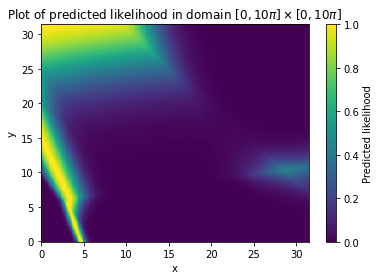

In [13]:
fig, ax = plt.subplots()
xx = np.arange(0,10*np.pi,0.1) 
yy = np.arange(0,10*np.pi,0.1) 
xx, yy = np.meshgrid(xx, yy)
grid = np.stack((yy, xx))
grid = grid.T.reshape(-1,2)
outs = model(torch.tensor(grid).float()/(10*np.pi)).detach().numpy()
y1 = outs.T[0].reshape(xx.shape[0],yy.shape[0])
im = plt.pcolormesh(xx, yy,likelihood0(y1,mu=mu,sigma=sigma))
fig.colorbar(im, ax=ax,label='Predicted likelihood')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Plot of predicted likelihood in domain $[0,10\pi]\times[0,10\pi]$')
plt.show()
plt.show()

## Import pseudo-likelihood (includes uncertainty)

In [14]:
from recommend import likelihood_u

## Now, we want to test the recommendation setup

In [15]:
from recommend import recommend_uncertainty

Iteration  1
Needed 0 min and 0.4 s to recommend 100 new points.
Efficency 1 sigma =  0.09
Efficency 2 sigma =  0.12


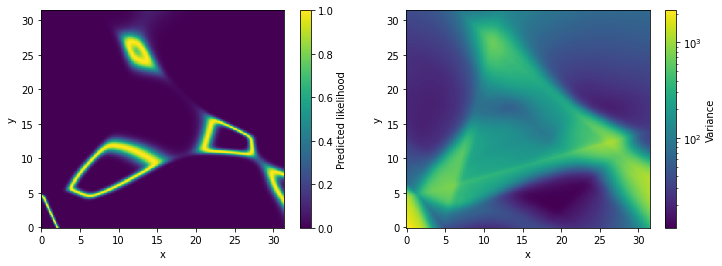

Iteration  2
Needed 0 min and 0.5 s to recommend 100 new points.
Efficency 1 sigma =  0.09
Efficency 2 sigma =  0.12


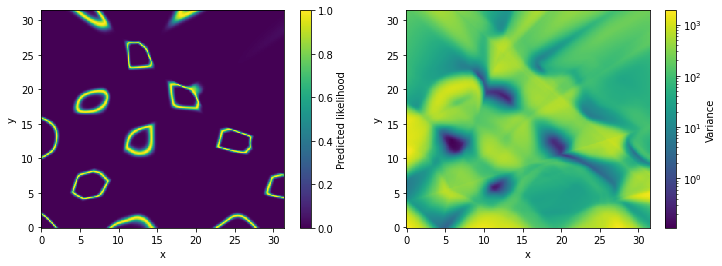

Iteration  3
Needed 0 min and 0.5 s to recommend 100 new points.
Efficency 1 sigma =  0.06
Efficency 2 sigma =  0.12


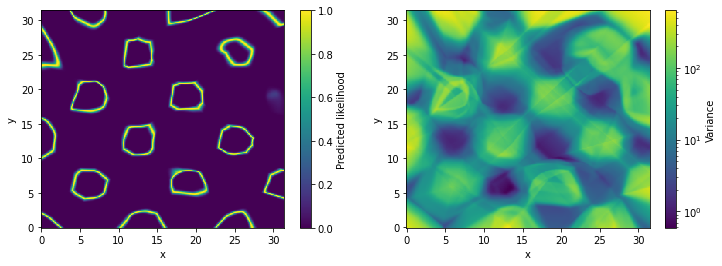

Iteration  4
Needed 0 min and 0.9 s to recommend 100 new points.
Efficency 1 sigma =  0.1
Efficency 2 sigma =  0.22


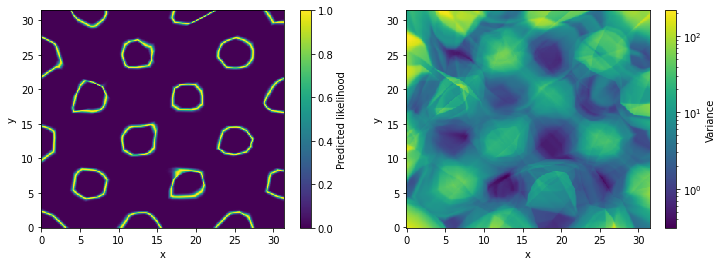

Iteration  5
Needed 0 min and 1.8 s to recommend 100 new points.
Efficency 1 sigma =  0.28
Efficency 2 sigma =  0.54


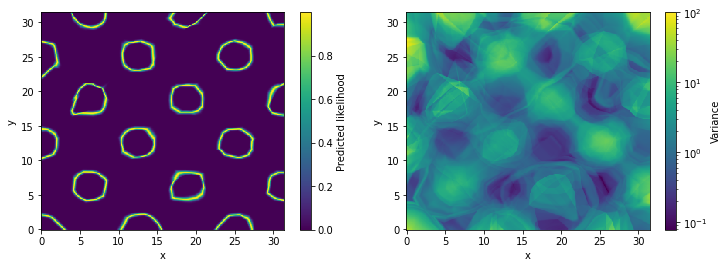

Iteration  6
Needed 0 min and 3.4 s to recommend 100 new points.
Efficency 1 sigma =  0.45
Efficency 2 sigma =  0.75


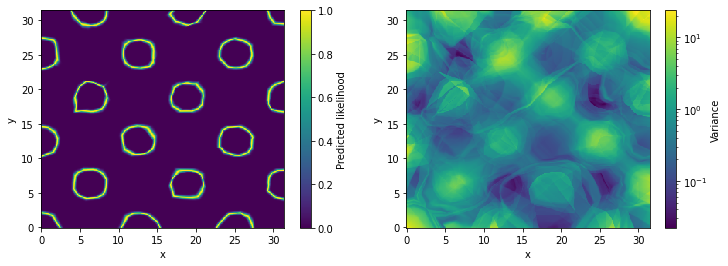

Iteration  7
Needed 0 min and 3.7 s to recommend 100 new points.
Efficency 1 sigma =  0.5
Efficency 2 sigma =  0.76


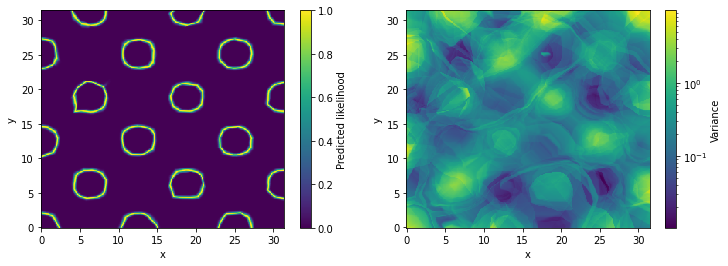

Iteration  8
Needed 0 min and 4.1 s to recommend 100 new points.
Efficency 1 sigma =  0.56
Efficency 2 sigma =  0.93


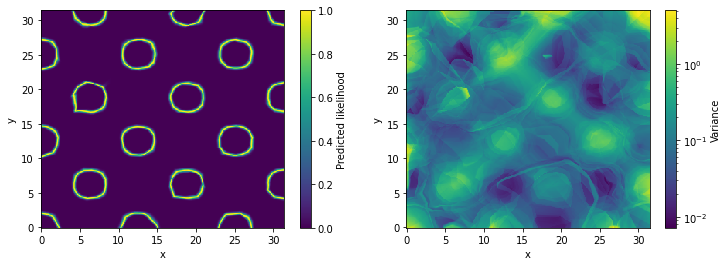

Iteration  9
Needed 0 min and 4.9 s to recommend 100 new points.
Efficency 1 sigma =  0.7
Efficency 2 sigma =  0.94


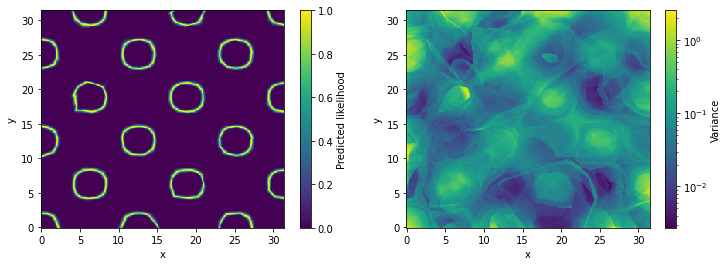

Iteration  10
Needed 0 min and 5.3 s to recommend 100 new points.
Efficency 1 sigma =  0.56
Efficency 2 sigma =  0.93


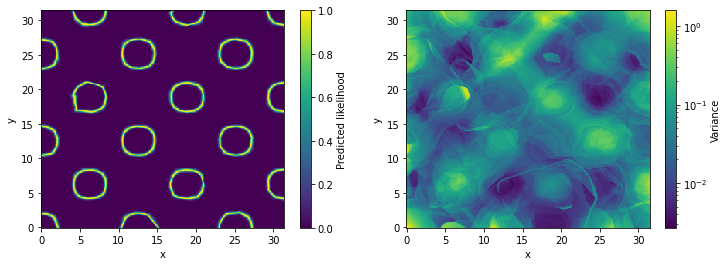

Iteration  11
Needed 0 min and 4.2 s to recommend 100 new points.
Efficency 1 sigma =  0.7
Efficency 2 sigma =  0.91


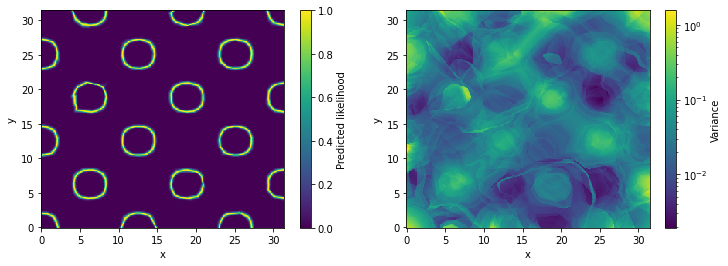

Iteration  12
Needed 0 min and 4.7 s to recommend 100 new points.
Efficency 1 sigma =  0.69
Efficency 2 sigma =  0.92


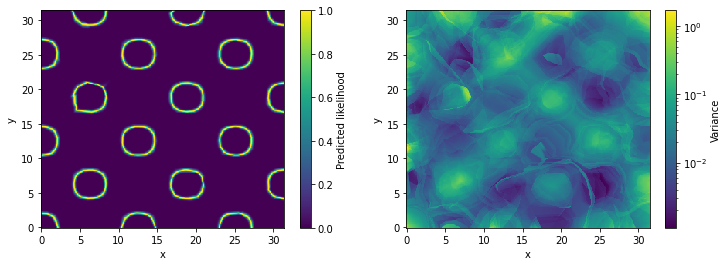

Iteration  13
Needed 0 min and 3.9 s to recommend 100 new points.
Efficency 1 sigma =  0.55
Efficency 2 sigma =  0.93


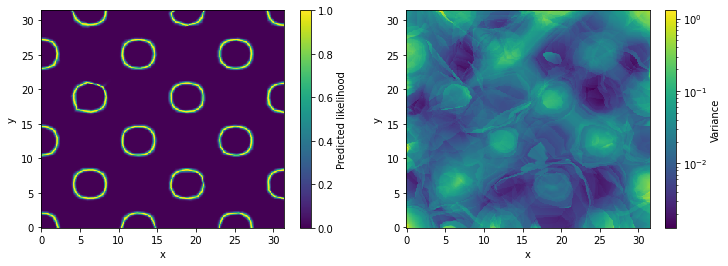

Iteration  14
Needed 0 min and 4.0 s to recommend 100 new points.
Efficency 1 sigma =  0.62
Efficency 2 sigma =  0.96


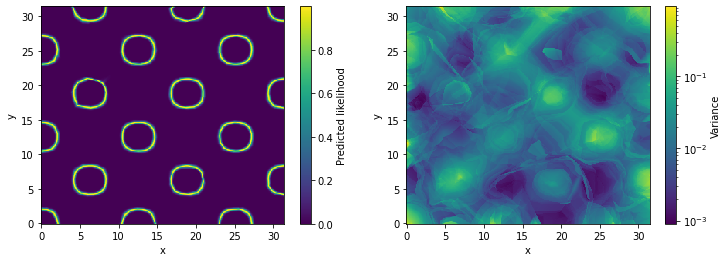

Iteration  15
Needed 0 min and 4.6 s to recommend 100 new points.
Efficency 1 sigma =  0.68
Efficency 2 sigma =  0.93


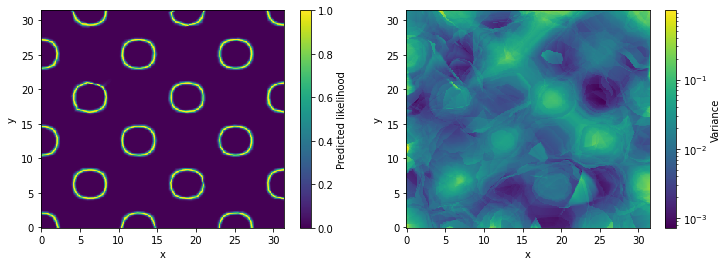

Iteration  16
Needed 0 min and 4.7 s to recommend 100 new points.
Efficency 1 sigma =  0.68
Efficency 2 sigma =  0.95


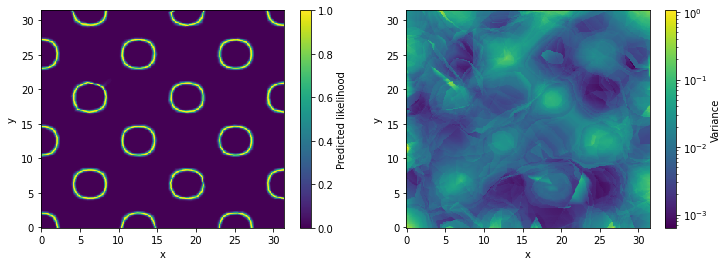

Iteration  17
Needed 0 min and 4.4 s to recommend 100 new points.
Efficency 1 sigma =  0.61
Efficency 2 sigma =  0.93


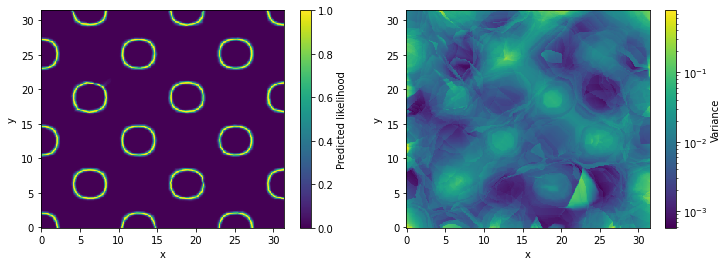

Iteration  18
Needed 0 min and 4.3 s to recommend 100 new points.
Efficency 1 sigma =  0.7
Efficency 2 sigma =  0.99


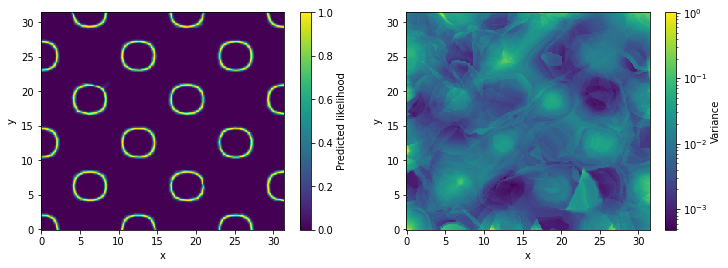

Iteration  19
Needed 0 min and 4.8 s to recommend 100 new points.
Efficency 1 sigma =  0.63
Efficency 2 sigma =  0.96


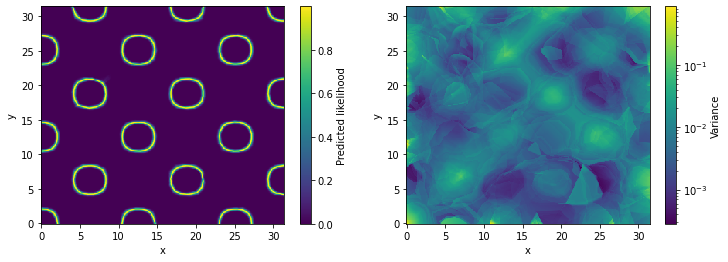

Iteration  20
Needed 0 min and 5.0 s to recommend 100 new points.
Efficency 1 sigma =  0.66
Efficency 2 sigma =  0.93


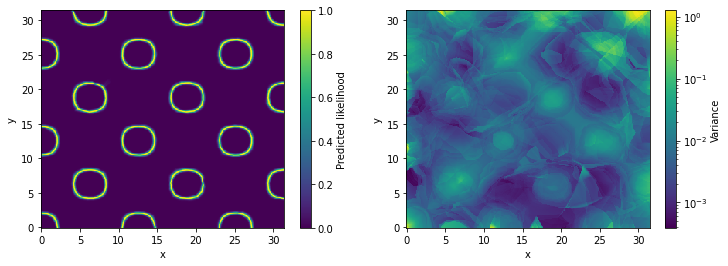

Iteration  21
Needed 0 min and 4.4 s to recommend 100 new points.
Efficency 1 sigma =  0.62
Efficency 2 sigma =  0.97


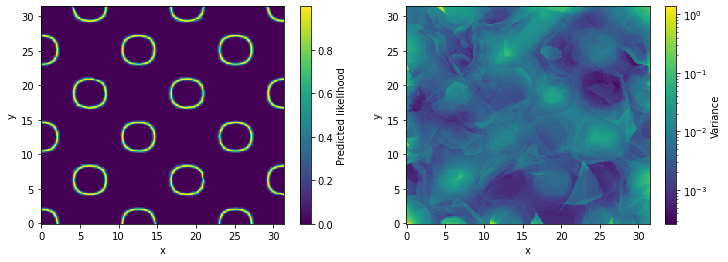

Iteration  22
Needed 0 min and 4.8 s to recommend 100 new points.
Efficency 1 sigma =  0.62
Efficency 2 sigma =  0.94


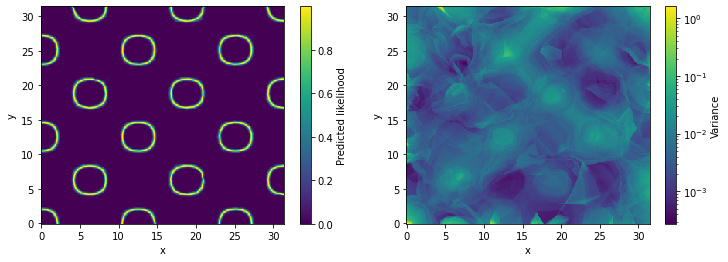

Iteration  23
Needed 0 min and 5.0 s to recommend 100 new points.
Efficency 1 sigma =  0.63
Efficency 2 sigma =  0.94


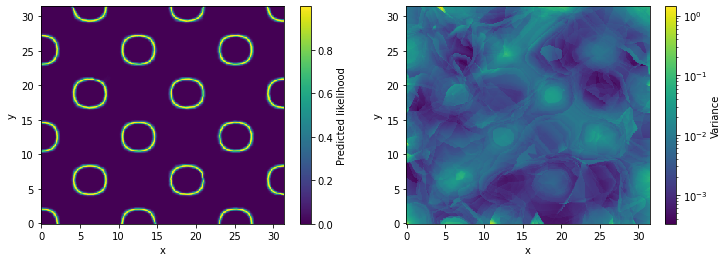

Iteration  24
Needed 0 min and 5.4 s to recommend 100 new points.
Efficency 1 sigma =  0.64
Efficency 2 sigma =  0.91


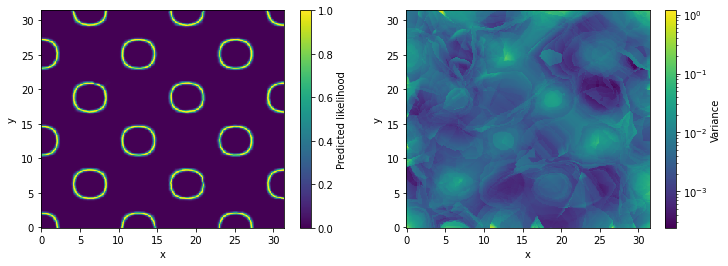

Iteration  25
Needed 0 min and 5.0 s to recommend 100 new points.
Efficency 1 sigma =  0.61
Efficency 2 sigma =  0.93


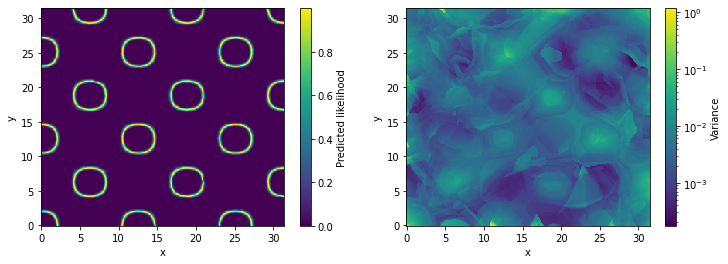

Iteration  26
Needed 0 min and 4.1 s to recommend 100 new points.
Efficency 1 sigma =  0.64
Efficency 2 sigma =  0.96


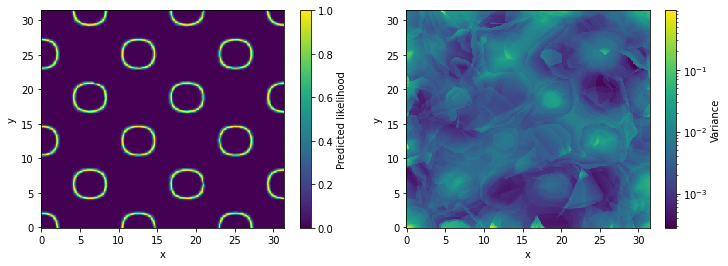

Iteration  27
Needed 0 min and 5.1 s to recommend 100 new points.
Efficency 1 sigma =  0.7
Efficency 2 sigma =  0.97


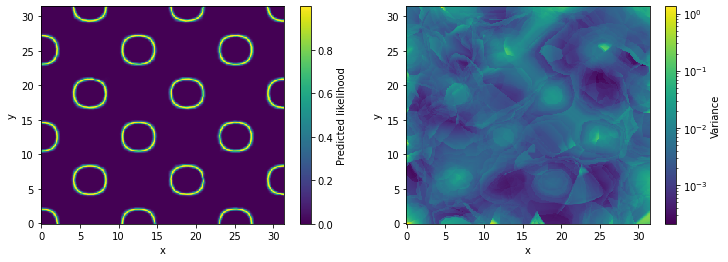

Iteration  28
Needed 0 min and 4.3 s to recommend 100 new points.
Efficency 1 sigma =  0.67
Efficency 2 sigma =  0.96


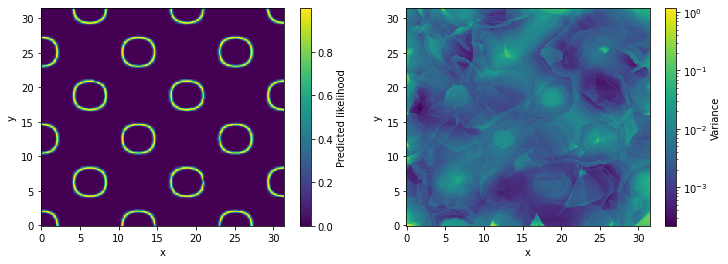

Iteration  29
Needed 0 min and 4.4 s to recommend 100 new points.
Efficency 1 sigma =  0.71
Efficency 2 sigma =  0.98


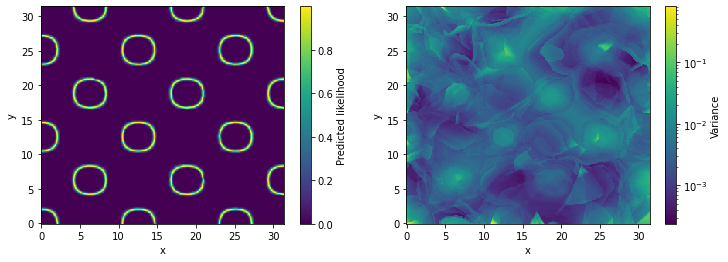

In [16]:
for num in np.arange(1,30,1): 
    print("Iteration ",num)
    #################### recommendation step #############################

    newdat = recommend_uncertainty(newdat, model, func, mu, sigma, num, scale= 10*np.pi)
    
    if num > 10: batch_size = round(len(newdat)/10)
    train_dataloader = DataLoader(newdat, batch_size=batch_size,
                                  shuffle=True)
    
    ################# training step #################################

    for epoch in range(num_epochs):
            model.train()
            for idx, batch in enumerate(train_dataloader):
                optimizer.zero_grad()
                outputs = model(batch[:,:-1].float()/(10*np.pi))
                targets = batch[:,-1].unsqueeze(1).float()
                loss = criterion(outputs, targets)
                kl = kl_loss(model)
                cost = loss + kl_weight*kl
                cost.backward()
                optimizer.step()
    fig, ax = plt.subplots(1,2, figsize=(12, 4))
    xx = np.arange(0,10*np.pi,0.1) 
    yy = np.arange(0,10*np.pi,0.1) 
    xx, yy = np.meshgrid(xx, yy)
    grid = np.stack((yy, xx))
    grid = grid.T.reshape(-1,2)
################# compute mean and variance of prediction using 50 BNN passes ######
    for i in range(50):
        model.eval()
        outs = model(torch.tensor(grid).float()/(10*np.pi)).detach().numpy()
        if i == 0: full_output = outs
        else: full_output = np.append(full_output,outs,axis=-1)

    mean = full_output.mean(axis=-1)
    var = full_output.var(axis=-1)


######################## plotting ########################
    y1 = mean.T.reshape(xx.shape[0],yy.shape[0])
    im1 = ax[0].pcolormesh(xx, yy,likelihood0(y1,mu=mu,sigma=sigma))
    fig.colorbar(im1, label='Predicted likelihood',ax=ax[0])
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    y2 = var.T.reshape(xx.shape[0],yy.shape[0])
    im2 = ax[1].pcolormesh(xx,yy,y2,norm=colors.LogNorm(vmin=y2.min(), vmax=y2.max()))
    fig.colorbar(im2, label='Variance',ax=ax[1])
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    plt.show()
